In [ ]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import torch.nn.functional as F
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.isotonic import IsotonicRegression
import math

In [ ]:
train_x_slide = torch.load('./Downloads/train_x_slide.pt')
train_y_slide = torch.load('./Downloads/train_y_slide.pt')
train_y_gan = torch.load('./Downloads/train_y_gan.pt')
test_x_slide = torch.load('./Downloads/test_x_slide.pt')
test_y_slide = torch.load('./Downloads/test_y_slide.pt')
test_y_gan = torch.load('./Downloads/test_y_gan.pt')
validation_x_slide = torch.load('./Downloads/validation_x_slide.pt')
validation_y_slide = torch.load('./Downloads/validation_y_slide.pt')
validation_y_gan = torch.load('./Downloads/validation_y_gan.pt')


print(f'validation_x_slide: {validation_x_slide.shape}')
print(f'validation_y_slide: {validation_y_slide.shape}')
print(f'validation_y_gan: {validation_y_gan.shape}')
print(f'train_x_slide: {train_x_slide.shape}')
print(f'train_y_slide: {train_y_slide.shape}')
print(f'train_y_gan: {train_y_gan.shape}')
print(f'test_x_slide: {test_x_slide.shape}')
print(f'test_y_slide: {test_y_slide.shape}')
print(f'test_y_gan: {test_y_gan.shape}')

validation_x_slide: torch.Size([397, 3, 35])
validation_y_slide: torch.Size([397, 1])
validation_y_gan: torch.Size([397, 4, 1])
train_x_slide: torch.Size([1862, 3, 35])
train_y_slide: torch.Size([1862, 1])
train_y_gan: torch.Size([1862, 4, 1])
test_x_slide: torch.Size([397, 3, 35])
test_y_slide: torch.Size([397, 1])
test_y_gan: torch.Size([397, 4, 1])


In [ ]:
class Generator(nn.Module):
    def __init__(self, input_size, use_cuda):
        super().__init__()
        self.lstm_1 = nn.LSTM(input_size, 1024, batch_first=True)
        self.lstm_2 = nn.LSTM(1024, 512, batch_first=True)
        self.lstm_3 = nn.LSTM(512, 256, batch_first=True)
        self.linear_1 = nn.Linear(256, 128)
        self.linear_2 = nn.Linear(128, 64)
        self.linear_3 = nn.Linear(64, 1)
        self.dropout = nn.Dropout(0.2)

    def forward(self, x):
        use_cuda = 1
        device = torch.device("cuda" if (torch.cuda.is_available() & use_cuda) else "cpu")
        h0 = torch.zeros(1, x.size(0), 1024).to(device)
        c0 = torch.zeros(1, x.size(0), 1024).to(device)
        out_1, _ = self.lstm_1(x, (h0, c0))
        out_1 = self.dropout(out_1)
        h1 = torch.zeros(1, x.size(0), 512).to(device)
        c1 = torch.zeros(1, x.size(0), 512).to(device)
        out_2, _ = self.lstm_2(out_1, (h1, c1))
        out_2 = self.dropout(out_2)
        h2 = torch.zeros(1, x.size(0), 256).to(device)
        c2 = torch.zeros(1, x.size(0), 256).to(device)
        out_3, _ = self.lstm_3(out_2, (h2, c2))
        out_3 = self.dropout(out_3)
        out_4 = self.linear_1(out_3[:, -1, :])
        out_5 = self.linear_2(out_4)
        out = self.linear_3(out_5)
        return out

class Discriminator(nn.Module):
    def __init__(self, real_tick):
        super().__init__()
        self.conv1 = nn.Conv1d(real_tick+1, 32, kernel_size = 3, stride = 1, padding = 'same')
        self.conv2 = nn.Conv1d(32, 64, kernel_size = 3, stride = 1, padding = 'same')
        self.conv3 = nn.Conv1d(64, 128, kernel_size = 3, stride = 1, padding = 'same')
        self.linear1 = nn.Linear(128, 220)
        self.batch1 = nn.BatchNorm1d(220)
        self.linear2 = nn.Linear(220, 220)
        self.batch2 = nn.BatchNorm1d(220)
        self.linear3 = nn.Linear(220, 1)
        self.leaky = nn.LeakyReLU(0.01)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        conv1 = self.conv1(x)
        conv1 = self.leaky(conv1)
        conv2 = self.conv2(conv1)
        conv2 = self.leaky(conv2)
        conv3 = self.conv3(conv2)
        conv3 = self.leaky(conv3)
        flatten_x = conv3.reshape(conv3.shape[0], conv3.shape[1])
        out_1 = self.linear1(flatten_x)
        out_1 = self.leaky(out_1)
        out_2 = self.linear2(out_1)
        out_2 = self.relu(out_2)
        out_3 = self.linear3(out_2)
        out = self.sigmoid(out_3)
        return out

In [ ]:


class GAN(nn.Module):
    def __init__(self, input_size, seq_length, use_cuda=1):
        super().__init__()
        self.input_size = input_size
        self.device = torch.device("cuda" if (torch.cuda.is_available() and use_cuda) else "cpu")
        self.gen = Generator(self.input_size, use_cuda)
        self.dis = Discriminator(seq_length)
        self.criterion = nn.BCELoss()

    def forward(self, z):
        return self.gen(z)

    def discriminator_loss(self, real_output, fake_output):
        real_labels = torch.ones_like(real_output, device=self.device)
        fake_labels = torch.zeros_like(fake_output, device=self.device)
        real_loss = self.criterion(real_output, real_labels)
        fake_loss = self.criterion(fake_output, fake_labels)
        total_loss = real_loss + fake_loss
        return total_loss

    def generator_loss(self, fake_output):
        real_labels = torch.ones_like(fake_output, device=self.device)  # Generator tries to fool discriminator
        loss = self.criterion(fake_output, real_labels)
        return loss

    def optimizers(self, lr):
        self.opt_G = torch.optim.Adam(self.gen.parameters(), lr=lr, betas=(0, 0.999))
        self.opt_D = torch.optim.Adam(self.dis.parameters(), lr=lr, betas=(0, 0.999))


##Training

In [ ]:
class MHGAN(GAN):
    def __init__(self, input_size, seq_length, use_cuda=1):
        super().__init__(input_size, seq_length, use_cuda)
        self.seq_length = seq_length
        self.calibrator = None

    def generator_samples(self, train_x):
        self.gen.eval()
        with torch.no_grad():

            mh_sample = self.gen(train_x)
        return mh_sample

    def score_sample(self, mh_sample_cat):
        self.dis.eval()
        with torch.no_grad():
            mh_sample_dis = self.dis(mh_sample_cat.to(self.device))
        return mh_sample_dis

    def calibrate_discriminator(self, train_x, train_y):
        self.calibrator = IsotonicRegression()
        mh_sample_predict = self.generator_samples(train_x)

        train_y_gpu = train_y[:, :self.seq_length, :].to(self.device)
        mh_sample_cat = torch.cat([train_y_gpu, mh_sample_predict.reshape(-1, 1, 1)], axis=1)

        mh_sample_dis = self.score_sample(mh_sample_cat.float())
        self.calibrator.fit(mh_sample_dis.cpu(), train_y[:, self.seq_length, :].reshape(-1))
        mh_sample_cal = self.calibrator.predict(mh_sample_dis.cpu())
        return mh_sample_cal

    def num_sampler(self, n_samples, x_shape):
        random_pick = []
        for _ in range(n_samples):
            random_pick.append(np.random.randint(0, x_shape - 1))
        return random_pick

    def mh_sample(self, train_x, train_y, mh_sample_cal):
        y_score_base = mh_sample_cal[0]
        x_samples = []
        y_samples = []

        while len(x_samples) < 2000:
            idx = self.num_sampler(1, train_x.shape[0])
            x_sample = train_x[idx, :, :]
            y_sample = train_y[idx, :, :]


            pred_x = self.generator_samples(x_sample)
            x_smaple_cat = torch.cat([y_sample[:, :self.seq_length, :].float().to(self.device),
                                      pred_x.reshape(-1, 1, 1)], axis=1)
            x_dis_score = self.score_sample(x_smaple_cat)
            x_score = self.calibrator.transform(x_dis_score.cpu().detach().numpy())

            u = np.random.uniform(0, 1, (1,))[0]
            if u <= np.fmin(1., (1. / y_score_base - 1.) / (1. / x_score - 1.)):
                y_score_base = x_score
                x_samples.append(x_sample.squeeze(0))  # Remove single-sample dimension for stacking
                y_samples.append(y_sample.squeeze(0))

        # Convert lists of tensors to stacked tensors
        x_samples_tensor = torch.stack(x_samples)  # Stacks along a new dimension
        y_samples_tensor = torch.stack(y_samples)

        # Print lengths of x_samples and y_samples and shapes of train_x and train_y
        print(f"Length of x_samples: {len(x_samples_tensor)}, Length of y_samples: {len(y_samples_tensor)}")
        print(f"Shape of train_x: {train_x.shape}, Shape of train_y: {train_y.shape}")

        #return np.array(x_samples).reshape(-1, train_x.shape[1], train_x.shape[2]), np.array(y_samples).reshape(-1, train_y.shape[1], train_y.shape[2])
        return x_samples_tensor, y_samples_tensor





    def check_type(self, type):
        if type == 'mh':
            return True
        else:
            return False

    def training_model(self, epochs, type, batch_size, train_x, train_y, seq_length):
        history_G = np.zeros(epochs)
        history_D = np.zeros(epochs)
        for epoch in range(epochs):
            total_loss_G = 0
            total_loss_D = 0

            if self.check_type(type):
                mh_sample_cal = self.calibrate_discriminator(train_x, train_y)
                train_x, train_y = self.mh_sample(train_x, train_y, mh_sample_cal)

            dataset = DataLoader(TensorDataset(train_x,train_y), batch_size=batch_size, shuffle=False)

            self.dis.train()
            self.gen.train()
            for x, y in dataset:
                x = x.to(self.device)
                y = y.to(self.device)
                fake_data = self.gen(x)
                fake_data = torch.cat([y[:, :seq_length, :], fake_data.reshape(-1, 1, 1)], axis=1)

                cirtic_real = self.dis(y)
                critic_fake = self.dis(fake_data)

                loss_d = self.discriminator_loss(cirtic_real, critic_fake)
                self.dis.zero_grad()
                loss_d.backward(retain_graph=True)
                self.opt_D.step()

                output_fake = self.dis(fake_data)
                loss_g = self.generator_loss(output_fake)
                self.gen.zero_grad()
                loss_g.backward()
                self.opt_G.step()

                total_loss_G += loss_g.item()
                total_loss_D += loss_d.item()
            history_G[epoch] = total_loss_G
            history_D[epoch] = total_loss_D
            print(f'[{epoch + 1}/{epochs}] LossD: {total_loss_D:.5f} LossG: {total_loss_G:.5f}')
        return history_G, history_D

    def mh_training(self, epochs_gan, epochs_mhgan, batch_size, train_x, train_y, seq_length, plot_loss=True):
        hist_G = np.zeros(epochs_gan + epochs_mhgan)
        hist_D = np.zeros(epochs_gan + epochs_mhgan)

        print(f'Training Basic for {epochs_gan} epochs')
        gan_loss_G, gan_loss_D = self.training_model(epochs_gan, 'gan', batch_size, train_x, train_y, seq_length)

        for i in range(epochs_gan):
            hist_G[i] = gan_loss_G[i]
            hist_D[i] = gan_loss_D[i]

        print(f'Training MH for {epochs_mhgan} epochs')
        mhgan_loss_G, mhgan_loss_D = self.training_model(epochs_mhgan, 'mh', batch_size, train_x, train_y, seq_length)

        for i in range(epochs_gan, epochs_gan + epochs_mhgan):
            hist_G[i] = mhgan_loss_G[i - epochs_gan]
            hist_D[i] = mhgan_loss_D[i - epochs_gan]

        if plot_loss:
            self.plot(hist_G, hist_D)


    def plot(self, hist_G, hist_D):
        plt.figure(figsize=(12, 6))
        plt.plot(hist_G, color='blue', label='Generator Loss')
        plt.plot(hist_D, color='orange', label='Discriminator Loss')
        plt.title('MHWGAN Loss')
        plt.xlabel('Epochs')
        plt.legend(loc='upper right')
        plt.show()

Training Basic for 165 epochs
[1/165] LossD: 20.79529 LossG: 10.52145
[2/165] LossD: 20.79400 LossG: 10.49193
[3/165] LossD: 20.79304 LossG: 10.46918
[4/165] LossD: 20.79246 LossG: 10.45156
[5/165] LossD: 20.79210 LossG: 10.43815
[6/165] LossD: 20.79203 LossG: 10.42769
[7/165] LossD: 20.79228 LossG: 10.41949
[8/165] LossD: 20.79285 LossG: 10.41284
[9/165] LossD: 20.79377 LossG: 10.40722
[10/165] LossD: 20.79501 LossG: 10.40139
[11/165] LossD: 20.79632 LossG: 10.39584
[12/165] LossD: 20.79715 LossG: 10.39108
[13/165] LossD: 20.79688 LossG: 10.38758
[14/165] LossD: 20.79555 LossG: 10.38556
[15/165] LossD: 20.79363 LossG: 10.38489
[16/165] LossD: 20.79220 LossG: 10.38525
[17/165] LossD: 20.79181 LossG: 10.38637
[18/165] LossD: 20.79223 LossG: 10.38818
[19/165] LossD: 20.79296 LossG: 10.39033
[20/165] LossD: 20.79374 LossG: 10.39262
[21/165] LossD: 20.79435 LossG: 10.39478
[22/165] LossD: 20.79478 LossG: 10.39679
[23/165] LossD: 20.79501 LossG: 10.39858
[24/165] LossD: 20.79510 LossG: 10.4

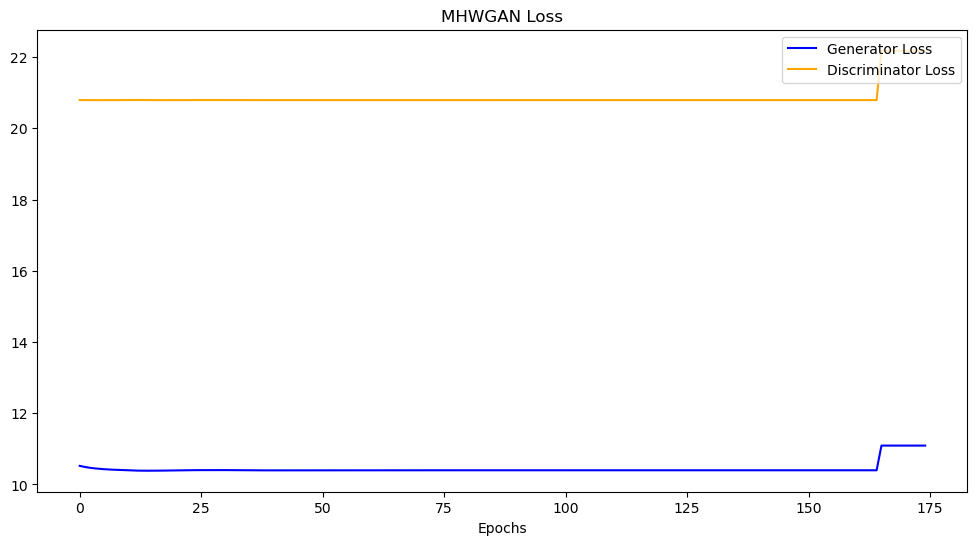

In [ ]:
use_cuda = 1
device = torch.device("cuda" if (torch.cuda.is_available() & use_cuda) else "cpu")
# Train the MHGAN model and will fine-tune the model later
mhgan = MHGAN(35, 3, 1)
mhgan.to(device)
init_epochs = 165
learning_rate = 0.0000115
batch_size = 128
mhgan.optimizers(lr=learning_rate)
seq_length = 3
MH_epochs = 10

# Use the whole dataset except testing data to train the model
mhgan.mh_training(init_epochs, MH_epochs, batch_size, train_x_slide, train_y_gan, seq_length)


In [ ]:

mhgan.eval()
pred_y_train = mhgan(train_x_slide.to(device))
pred_y_test = mhgan(test_x_slide.to(device))

y_train = train_y_slide
y_test = test_y_slide

print(pred_y_train)

tensor([[0.0227],
        [0.0217],
        [0.0206],
        ...,
        [0.2769],
        [0.2778],
        [0.2741]], grad_fn=<AddmmBackward0>)


In [ ]:
import pickle

# Load the saved scaler
y_scaler = pickle.load(open('./Downloads/target_scaler.pkl', 'rb'))

# Use the loaded scaler to inverse transform the data
rescaled_y_train = y_scaler.inverse_transform(y_train)
rescaled_y_test = y_scaler.inverse_transform(y_test)


rescaled_pred_y_train = y_scaler.inverse_transform(pred_y_train.detach().numpy())
rescaled_pred_y_test = y_scaler.inverse_transform(pred_y_test.detach().numpy())

Training dataset RMSE:1.1548598434414967


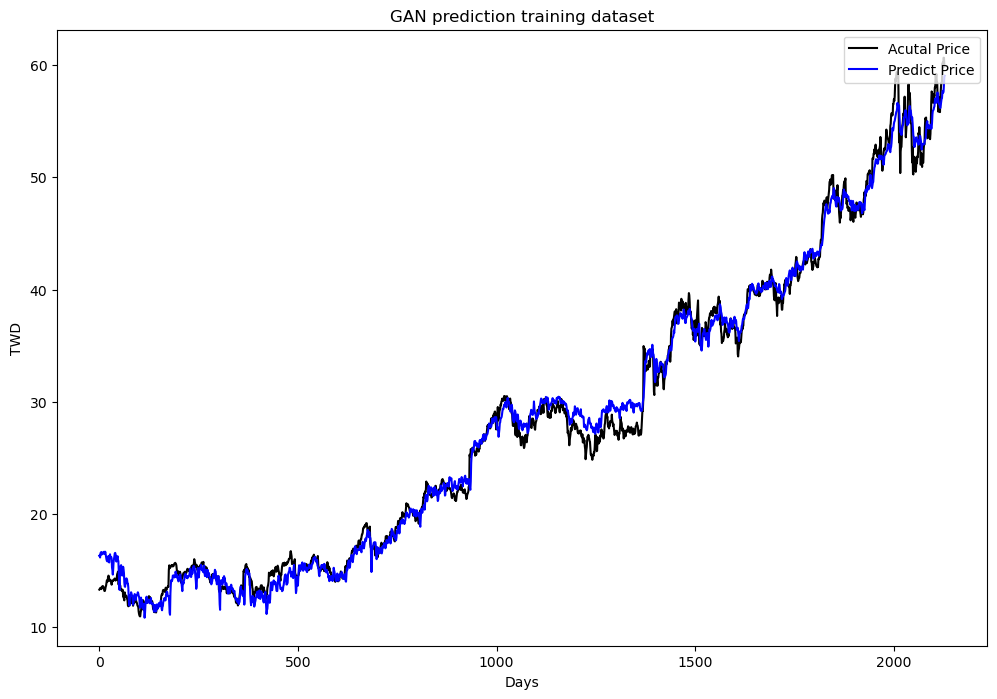

In [ ]:
plt.figure(figsize=(12, 8))
plt.plot(rescaled_y_train, color = 'black', label = 'Acutal Price')
plt.plot(rescaled_pred_y_train, color = 'blue', label = 'Predict Price')

plt.title('GAN prediction training dataset')
plt.ylabel('TWD')
plt.xlabel('Days')
plt.legend(loc = 'upper right')

MSE = mean_squared_error(rescaled_y_train, rescaled_pred_y_train)
RMSE = math.sqrt(MSE)
print(f'Training dataset RMSE:{RMSE}')

Training dataset RMSE:2.298639565240924


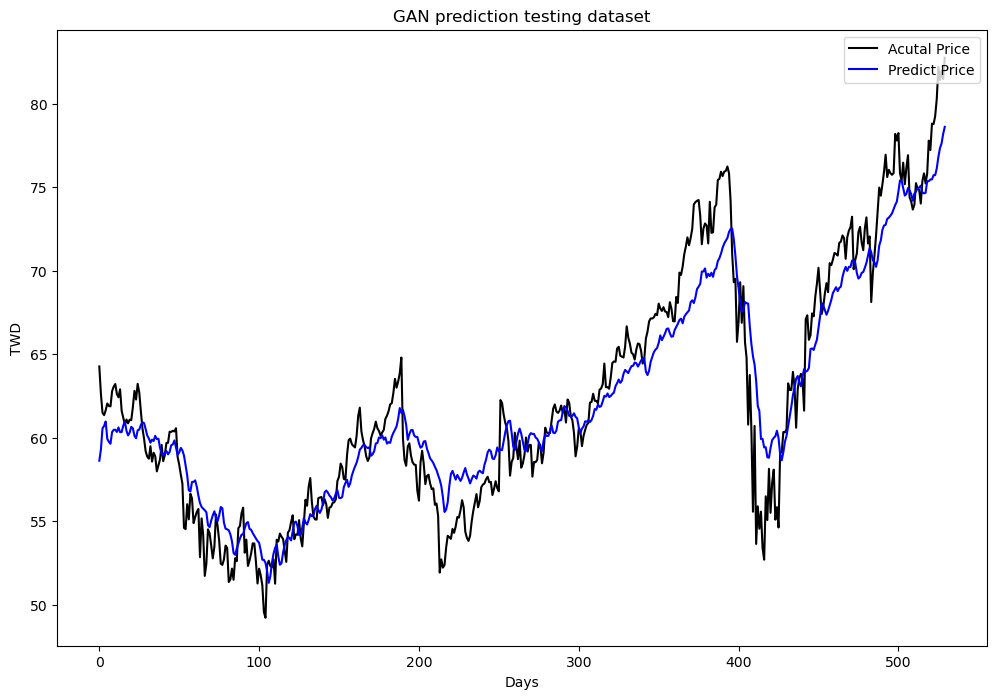

In [ ]:
plt.figure(figsize=(12, 8))
plt.plot(rescaled_y_test, color = 'black', label = 'Acutal Price')
plt.plot(rescaled_pred_y_test, color = 'blue', label = 'Predict Price')
plt.title('GAN prediction testing dataset')
plt.ylabel('TWD')
plt.xlabel('Days')
plt.legend(loc = 'upper right')

MSE = mean_squared_error(rescaled_y_test, rescaled_pred_y_test)
RMSE = math.sqrt(MSE)
print(f'Training dataset RMSE:{RMSE}')

##hyperparameter Tuning

Training Basic for 200 epochs
[1/200] LossD: 41.57870 LossG: 20.79806
[2/200] LossD: 41.57803 LossG: 20.80226
[3/200] LossD: 41.57802 LossG: 20.80202
[4/200] LossD: 41.58014 LossG: 20.80006
[5/200] LossD: 41.58024 LossG: 20.79924
[6/200] LossD: 41.57846 LossG: 20.80055
[7/200] LossD: 41.57774 LossG: 20.80059
[8/200] LossD: 41.57887 LossG: 20.80113
[9/200] LossD: 41.57775 LossG: 20.80115
[10/200] LossD: 41.57822 LossG: 20.80141
[11/200] LossD: 41.57764 LossG: 20.80170
[12/200] LossD: 41.57814 LossG: 20.80098
[13/200] LossD: 41.57919 LossG: 20.80048
[14/200] LossD: 41.57622 LossG: 20.80102
[15/200] LossD: 41.57847 LossG: 20.80232
[16/200] LossD: 41.57788 LossG: 20.80134
[17/200] LossD: 41.57706 LossG: 20.80036
[18/200] LossD: 41.57860 LossG: 20.80115
[19/200] LossD: 41.57597 LossG: 20.80213
[20/200] LossD: 41.57762 LossG: 20.80179
[21/200] LossD: 41.57642 LossG: 20.80281
[22/200] LossD: 41.57888 LossG: 20.80137
[23/200] LossD: 41.57472 LossG: 20.80204
[24/200] LossD: 41.57820 LossG: 20.8

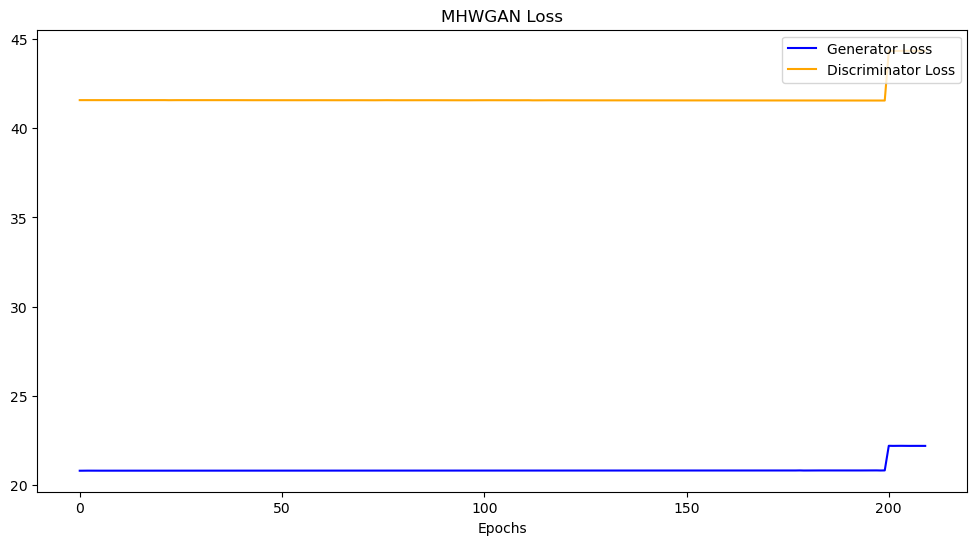

1.8590102419049426
Training Basic for 200 epochs
[1/200] LossD: 41.55888 LossG: 20.81337
[2/200] LossD: 41.55961 LossG: 20.81009
[3/200] LossD: 41.55833 LossG: 20.81321
[4/200] LossD: 41.55747 LossG: 20.81609
[5/200] LossD: 41.56037 LossG: 20.81664
[6/200] LossD: 41.54710 LossG: 20.81690
[7/200] LossD: 41.55936 LossG: 20.81741
[8/200] LossD: 41.55385 LossG: 20.81314
[9/200] LossD: 41.55098 LossG: 20.81586
[10/200] LossD: 41.55458 LossG: 20.81924
[11/200] LossD: 41.55017 LossG: 20.81669
[12/200] LossD: 41.55602 LossG: 20.81298
[13/200] LossD: 41.55005 LossG: 20.81905
[14/200] LossD: 41.55783 LossG: 20.81749
[15/200] LossD: 41.55856 LossG: 20.81287
[16/200] LossD: 41.55204 LossG: 20.81594
[17/200] LossD: 41.55448 LossG: 20.81764
[18/200] LossD: 41.54858 LossG: 20.81840
[19/200] LossD: 41.55620 LossG: 20.81824
[20/200] LossD: 41.56014 LossG: 20.81208
[21/200] LossD: 41.55339 LossG: 20.81581
[22/200] LossD: 41.55095 LossG: 20.82013
[23/200] LossD: 41.55303 LossG: 20.81882
[24/200] LossD: 4

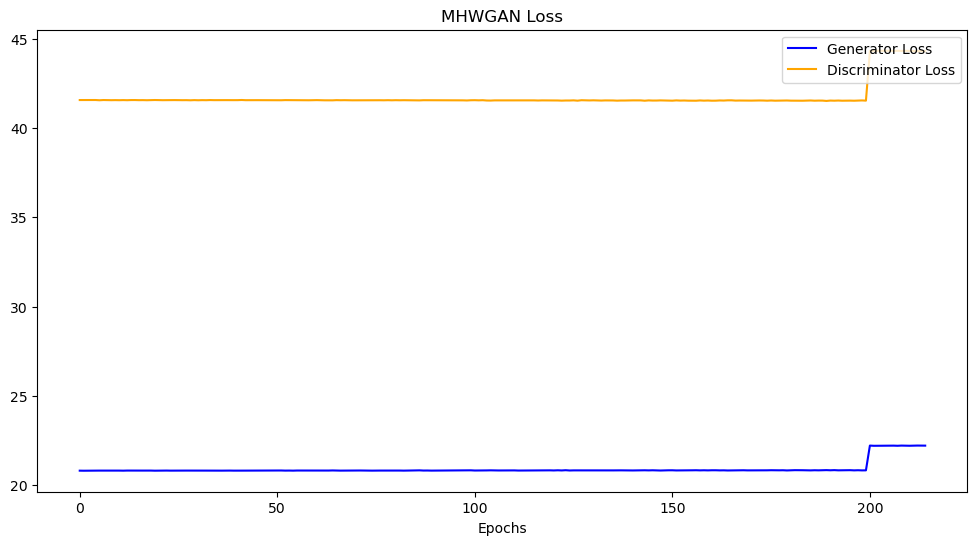

2.0812638923562794
Training Basic for 200 epochs
[1/200] LossD: 41.52423 LossG: 20.83462
[2/200] LossD: 41.52423 LossG: 20.84689
[3/200] LossD: 41.52451 LossG: 20.84717
[4/200] LossD: 41.50652 LossG: 20.84366
[5/200] LossD: 41.51143 LossG: 20.84788
[6/200] LossD: 41.51258 LossG: 20.84366
[7/200] LossD: 41.51454 LossG: 20.85421
[8/200] LossD: 41.52892 LossG: 20.83798
[9/200] LossD: 41.51745 LossG: 20.84154
[10/200] LossD: 41.51827 LossG: 20.83647
[11/200] LossD: 41.52137 LossG: 20.83822
[12/200] LossD: 41.50670 LossG: 20.84060
[13/200] LossD: 41.51985 LossG: 20.83822
[14/200] LossD: 41.51675 LossG: 20.83548
[15/200] LossD: 41.50599 LossG: 20.84035
[16/200] LossD: 41.52366 LossG: 20.84309
[17/200] LossD: 41.50960 LossG: 20.84055
[18/200] LossD: 41.52649 LossG: 20.84022
[19/200] LossD: 41.50680 LossG: 20.84216
[20/200] LossD: 41.51410 LossG: 20.84628
[21/200] LossD: 41.51049 LossG: 20.84024
[22/200] LossD: 41.51326 LossG: 20.83962
[23/200] LossD: 41.51248 LossG: 20.84021
[24/200] LossD: 4

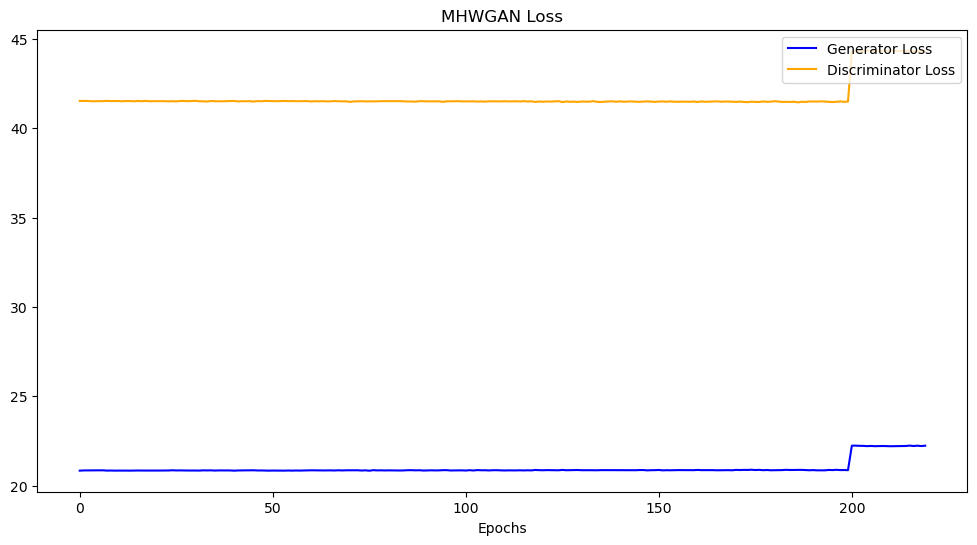

2.2456468760318855
Training Basic for 200 epochs
[1/200] LossD: 41.49328 LossG: 20.84571
[2/200] LossD: 41.49086 LossG: 20.86819
[3/200] LossD: 41.47321 LossG: 20.88233
[4/200] LossD: 41.45958 LossG: 20.87400
[5/200] LossD: 41.47102 LossG: 20.87001
[6/200] LossD: 41.47380 LossG: 20.86914
[7/200] LossD: 41.45761 LossG: 20.88139
[8/200] LossD: 41.46485 LossG: 20.88151
[9/200] LossD: 41.48010 LossG: 20.86962
[10/200] LossD: 41.45292 LossG: 20.88985
[11/200] LossD: 41.46743 LossG: 20.88422
[12/200] LossD: 41.48019 LossG: 20.86995
[13/200] LossD: 41.44591 LossG: 20.87587
[14/200] LossD: 41.44840 LossG: 20.89133
[15/200] LossD: 41.48411 LossG: 20.88163
[16/200] LossD: 41.45012 LossG: 20.88169
[17/200] LossD: 41.46507 LossG: 20.88443
[18/200] LossD: 41.44397 LossG: 20.88587
[19/200] LossD: 41.45177 LossG: 20.89327
[20/200] LossD: 41.46577 LossG: 20.89543
[21/200] LossD: 41.44786 LossG: 20.88882
[22/200] LossD: 41.46005 LossG: 20.87649
[23/200] LossD: 41.47992 LossG: 20.87787
[24/200] LossD: 4

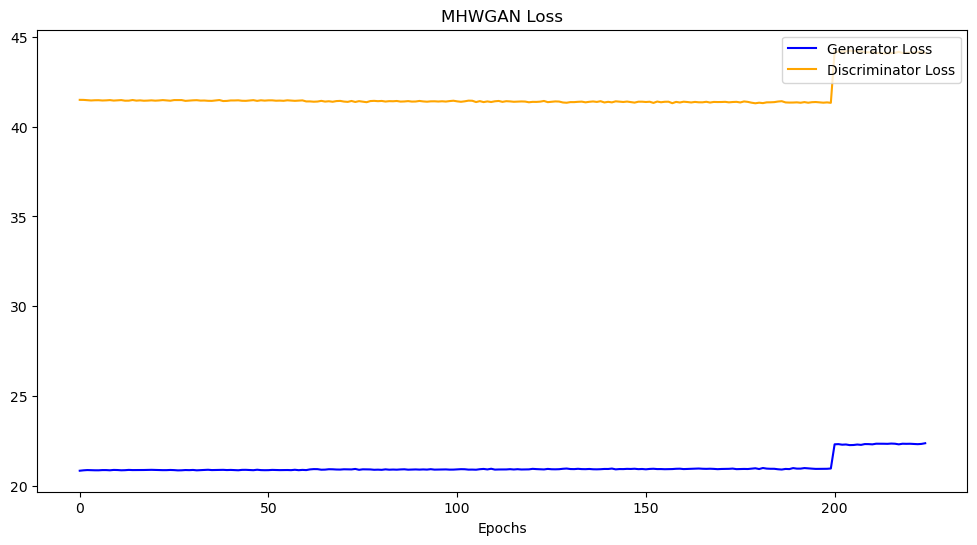

2.302555581983975
Training Basic for 200 epochs
[1/200] LossD: 41.32355 LossG: 20.93508
[2/200] LossD: 41.35582 LossG: 20.96124
[3/200] LossD: 41.33168 LossG: 20.97957
[4/200] LossD: 41.32151 LossG: 20.97252
[5/200] LossD: 41.34837 LossG: 20.98205
[6/200] LossD: 41.27594 LossG: 21.03933
[7/200] LossD: 41.30613 LossG: 20.97164
[8/200] LossD: 41.33637 LossG: 21.01002
[9/200] LossD: 41.35316 LossG: 20.98063
[10/200] LossD: 41.29011 LossG: 21.00454
[11/200] LossD: 41.27456 LossG: 21.01951
[12/200] LossD: 41.27501 LossG: 21.04154
[13/200] LossD: 41.34892 LossG: 20.96382
[14/200] LossD: 41.35372 LossG: 20.95476
[15/200] LossD: 41.34764 LossG: 20.97540
[16/200] LossD: 41.33472 LossG: 20.99013
[17/200] LossD: 41.35564 LossG: 20.96200
[18/200] LossD: 41.36800 LossG: 20.94801
[19/200] LossD: 41.33325 LossG: 20.97180
[20/200] LossD: 41.28525 LossG: 21.01416
[21/200] LossD: 41.29870 LossG: 20.99665
[22/200] LossD: 41.31855 LossG: 20.99907
[23/200] LossD: 41.31098 LossG: 21.00201
[24/200] LossD: 41

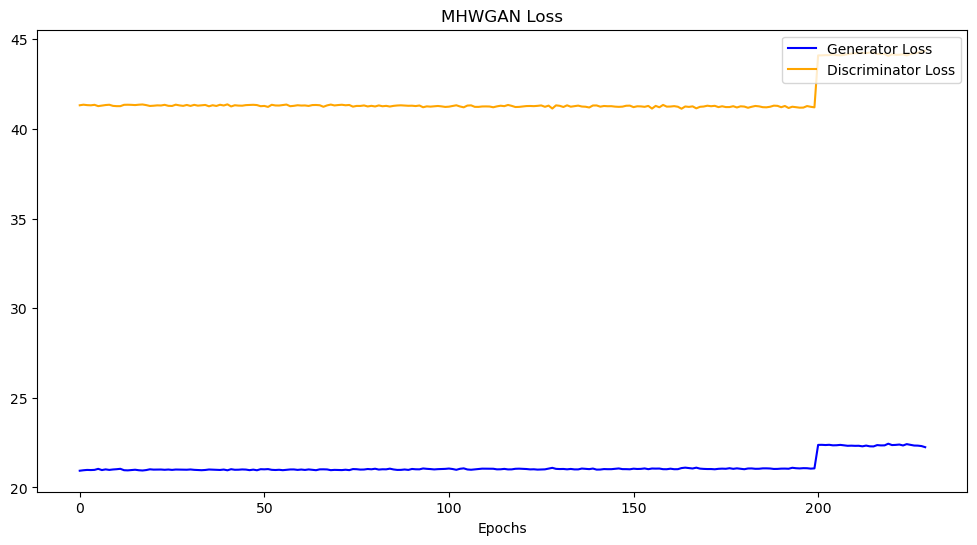

1.926071790450979
Best Parameters: {'batch_size': 64, 'learning_rate': 1e-05, 'num_epochs': 200, 'mh_epochs': 10}
Best RMSE: 1.8590102419049426


In [ ]:
learning_rate = 0.00001
batch_size = 64
num_epochs = 200
MH_epochs_options = [10,15,20, 25, 30]

best_rmse = float('inf')
best_params = {}

for MH_epochs in MH_epochs_options:
    use_cuda = 1
    device = torch.device("cuda" if (torch.cuda.is_available() & use_cuda) else "cpu")
    mhwgan = MHGAN(35, 3, 1)
    mhwgan.to(device)
    mhwgan.optimizers(lr=learning_rate)

    # Create a DataLoader with the chosen batch size
    trainDataloader = DataLoader(TensorDataset(train_x_slide, train_y_gan), batch_size=batch_size, shuffle=False)

    # Train the MHGAN model
    mhgan.mh_training(num_epochs, MH_epochs, batch_size, train_x_slide, train_y_gan, 3)


    pred_y_validation = mhgan(validation_x_slide.to(device))

    rescaled_y_validation = y_scaler.inverse_transform(validation_y_slide)

    rescaled_pred_y_validation = y_scaler.inverse_transform(pred_y_validation.detach().numpy())

    MSE_validation = mean_squared_error(rescaled_y_validation, rescaled_pred_y_validation)
    rmse = math.sqrt(MSE_validation)

    print(rmse)

    if rmse < best_rmse:
        best_rmse = rmse
        best_params = {'batch_size': batch_size, 'learning_rate': learning_rate, 'num_epochs': num_epochs, 'mh_epochs': MH_epochs}

print(f"Best Parameters: {best_params}")
print(f"Best RMSE: {best_rmse}")

Training Basic for 200 epochs
[1/200] LossD: 41.60426 LossG: 20.12328
[2/200] LossD: 41.59779 LossG: 20.25754
[3/200] LossD: 41.59325 LossG: 20.37172
[4/200] LossD: 41.59036 LossG: 20.46911
[5/200] LossD: 41.58861 LossG: 20.54924
[6/200] LossD: 41.58799 LossG: 20.61445
[7/200] LossD: 41.58816 LossG: 20.66569
[8/200] LossD: 41.58892 LossG: 20.70620
[9/200] LossD: 41.59024 LossG: 20.73638
[10/200] LossD: 41.59111 LossG: 20.76008
[11/200] LossD: 41.59033 LossG: 20.78045
[12/200] LossD: 41.58886 LossG: 20.79565
[13/200] LossD: 41.58800 LossG: 20.80388
[14/200] LossD: 41.58778 LossG: 20.80663
[15/200] LossD: 41.58804 LossG: 20.80554
[16/200] LossD: 41.58846 LossG: 20.80234
[17/200] LossD: 41.58885 LossG: 20.79849
[18/200] LossD: 41.58906 LossG: 20.79510
[19/200] LossD: 41.58914 LossG: 20.79238
[20/200] LossD: 41.58910 LossG: 20.79035
[21/200] LossD: 41.58895 LossG: 20.78898
[22/200] LossD: 41.58870 LossG: 20.78829
[23/200] LossD: 41.58839 LossG: 20.78821
[24/200] LossD: 41.58806 LossG: 20.7

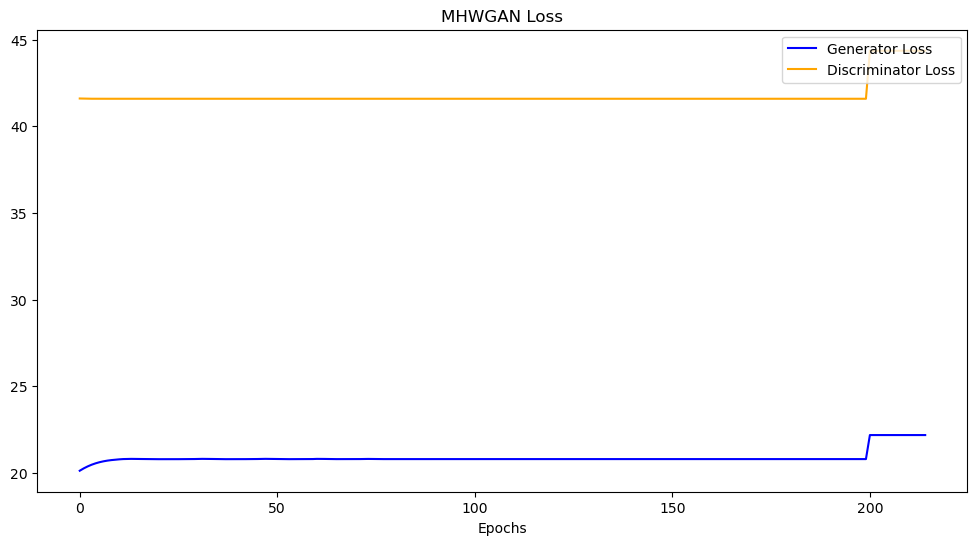

In [ ]:
use_cuda = 1
device = torch.device("cuda" if (torch.cuda.is_available() & use_cuda) else "cpu")
# Train the MHGAN model and will fine-tune the model later
mhgan = MHGAN(35, 3, 1)
mhgan.to(device)
init_epochs = 200
learning_rate = 0.00001
batch_size = 64
mhgan.optimizers(lr=learning_rate)
seq_length = 3
MH_epochs = 15

# Use the whole dataset except testing data to train the model
mhgan.mh_training(init_epochs, MH_epochs, batch_size, train_x_slide, train_y_gan, seq_length)

In [ ]:
mhgan.eval()
pred_y_train = mhgan(train_x_slide.to(device))
pred_y_test = mhgan(test_x_slide.to(device))

y_train = train_y_slide
y_test = test_y_slide

print(pred_y_train)

tensor([[0.0487],
        [0.0477],
        [0.0448],
        ...,
        [0.2688],
        [0.2677],
        [0.2689]], grad_fn=<AddmmBackward0>)


In [ ]:
import pickle

# Load the saved scaler
y_scaler = pickle.load(open('./Downloads/target_scaler.pkl', 'rb'))

# Use the loaded scaler to inverse transform the data
rescaled_y_train = y_scaler.inverse_transform(y_train)
rescaled_y_test = y_scaler.inverse_transform(y_test)


rescaled_pred_y_train = y_scaler.inverse_transform(pred_y_train.detach().numpy())
rescaled_pred_y_test = y_scaler.inverse_transform(pred_y_test.detach().numpy())

/opt/anaconda3/lib/python3.10/site-packages/sklearn/base.py:299: UserWarning: Trying to unpickle estimator MinMaxScaler from version 1.2.2 when using version 1.2.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


Training dataset RMSE:1.7507467585640597
Train dataset MAPE:0.08181782859419387
Train dataset MAE:1.4826324593292575


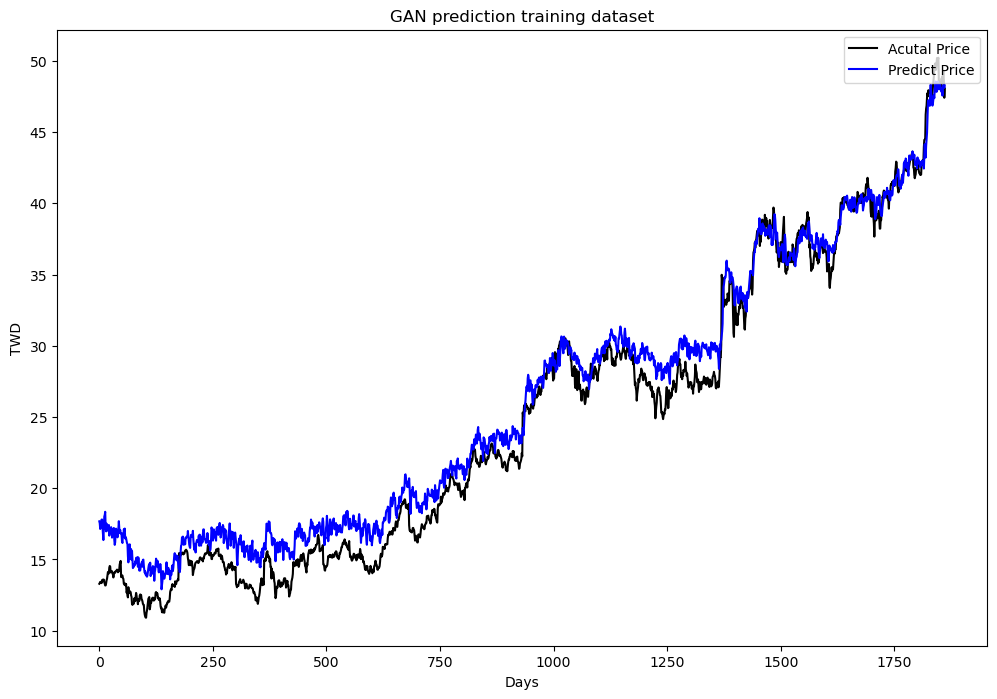

In [ ]:
plt.figure(figsize=(12, 8))
plt.plot(rescaled_y_train, color = 'black', label = 'Acutal Price')
plt.plot(rescaled_pred_y_train, color = 'blue', label = 'Predict Price')

plt.title('GAN prediction training dataset')
plt.ylabel('TWD')
plt.xlabel('Days')
plt.legend(loc = 'upper right')

MSE = mean_squared_error(rescaled_y_train, rescaled_pred_y_train)
RMSE = math.sqrt(MSE)
MAPE = mean_absolute_percentage_error(rescaled_y_train, rescaled_pred_y_train)
MAE = mean_absolute_error(rescaled_y_train, rescaled_pred_y_train)
print(f'Training dataset RMSE:{RMSE}')
print(f'Train dataset MAPE:{MAPE}')
print(f'Train dataset MAE:{MAE}')

Training dataset RMSE:3.2127957851413624
Train dataset MAPE:0.037475716399108204
Train dataset MAE:2.3037443222415788


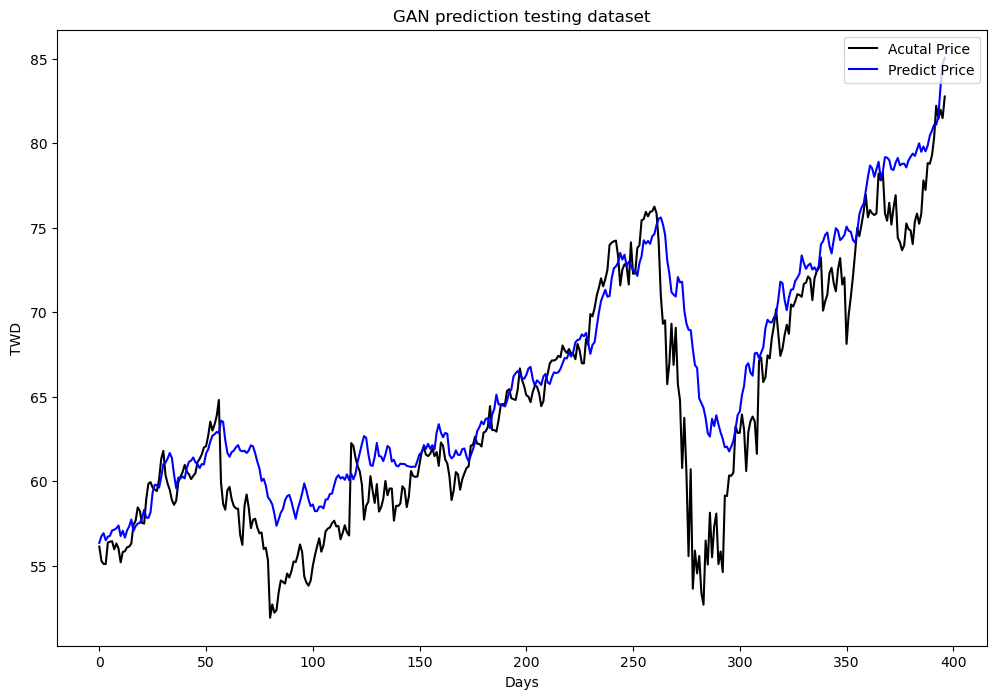

In [ ]:
plt.figure(figsize=(12, 8))
plt.plot(rescaled_y_test, color = 'black', label = 'Acutal Price')
plt.plot(rescaled_pred_y_test, color = 'blue', label = 'Predict Price')
plt.title('GAN prediction testing dataset')
plt.ylabel('TWD')
plt.xlabel('Days')
plt.legend(loc = 'upper right')

MSE = mean_squared_error(rescaled_y_test, rescaled_pred_y_test)
RMSE = math.sqrt(MSE)
MAPE = mean_absolute_percentage_error(rescaled_y_test, rescaled_pred_y_test)
MAE = mean_absolute_error(rescaled_y_test, rescaled_pred_y_test)
print(f'Training dataset RMSE:{RMSE}')
print(f'Train dataset MAPE:{MAPE}')
print(f'Train dataset MAE:{MAE}')

##Subsampling

In [ ]:
y_test = test_y_slide

subsample_rmses = []


# Iterate over the test set in windows of 50 days
for start in range(0, len(test_x_slide), 50):
    end = start + 50
    # If the last window has less than 50 days, we take whatever is remaining
    if end > len(test_x_slide):
        end = len(test_x_slide)

    # Slice the test set to get a subsample
    subsample_x = test_x_slide[start:end]
    subsample_y = y_test[start:end]

    # Make predictions on the subsample
    pred_y_subsample = mhgan(subsample_x.to(device))

    # Use the loaded scaler to inverse transform the data

    rescaled_y_test = y_scaler.inverse_transform(subsample_y)

    rescaled_pred_y_test = y_scaler.inverse_transform(pred_y_subsample.detach().numpy())

    MSE = mean_squared_error(rescaled_y_test, rescaled_pred_y_test)
    RMSE = math.sqrt(MSE)
    subsample_rmses.append(RMSE)


print(f'Subsample RMSE: {subsample_rmses}')

Subsample RMSE: [1.0735693053905355, 3.9206202766982656, 2.433934317174391, 1.1053533951964962, 1.2419221500118733, 6.451133185600989, 2.4926433375410753, 3.0795672383974644]


In [ ]:
df = pd.DataFrame(subsample_rmses, columns=['RMSE'])


df.to_csv('./Downloads/MHGANsubsample_rmses.csv', index=False)

